In [4]:
from underlying import Underlying
from option import Option
from trader import Trader

import matplotlib.pyplot as plt
from tqdm import tqdm
from quantile_hedging_calculator import *
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import lognorm
import scipy.integrate as integrate
from scipy.optimize import root_scalar


In [5]:
def payoff_call(X, K):
    return np.maximum(X.iloc[:,-1]- K, 0)
def payoff_put(X, K):
    return np.maximum(K - X.iloc[:,-1], 0)

In [6]:
mu = 0.06
sigma =  0.3
r = 0.05
T = 1
X0 = 100
repeat = 100


In [7]:
mu_tilde = 0.07
sigma_tilde = 0.02
rho = 0.3
S0 = 100
K = 70

**Call i Put**

In [15]:
def dP_dQ(mu, sigma, T, r, W_T): 
    return np.exp(W_T * (mu-r) / sigma + 0.5 * T * ((mu - r) / sigma) ** 2)
def integrand(y, S0, mu, sigma, rho, W_T_tilde, K, T, type = "call"):
    if type == "call":
        return 1 / np.sqrt(np.pi * 2 * T) / (S0 * np.exp(mu * T + sigma * W_T_tilde * rho + np.sqrt(1 - rho ** 2) * sigma * y - 0.5 * sigma ** 2 * T) - K) * np.exp(y ** 2 / (-2 * T) )
    elif type == "put":
        return 1 / np.sqrt(np.pi * 2 * T) / (K - S0 * np.exp(mu * T + sigma * W_T_tilde * rho + np.sqrt(1 - rho ** 2) * sigma * y - 0.5 * sigma ** 2 * T)) * np.exp(y ** 2 / (-2 * T) )
    else:
        raise Exception("Wrong type")
def G_func(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = "call", target_function = 1, derivative = False, arg_inf = 120):
    if x <= 0:
        raise Exception("x should be greater than 0")
    if type == "put" and x >= K:
        raise Exception("x should be  smaller than K")
    if derivative == False:
        if target_function == 1:
            if type == "call":
                return dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde) * norm.cdf((np.log((K+x)/S0) - mu * T + 0.5 * sigma ** 2 * T - sigma * rho * W_T_tilde)/ (sigma * np.sqrt(T * (1 - rho ** 2))))
            elif type == "put":
                return dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde) * (1 -norm.cdf((np.log((K-x)/S0) - mu * T + 0.5 * sigma ** 2 * T - sigma * rho * W_T_tilde)/ (sigma * np.sqrt(T * (1 - rho ** 2)))))
        elif target_function == 2:
            arg_inf = np.sqrt(arg_inf * T)
            if type == "call":
                g1 = G_func(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = "call", target_function = 1, derivative = False)
                a = (np.log((K + x)/ S0) - mu * T + sigma ** 2 * T * 0.5 - rho * sigma * W_T_tilde) / (sigma * np.sqrt(1 -rho ** 2))
                a_bis = max(a, -arg_inf)
                g2 = x * integrate.quad(integrand, a_bis, arg_inf, args = (S0, mu, sigma, rho, W_T_tilde, K, T, "call"))[0]
                return g1 + g2 * dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)
            elif type == "put":
                arg_inf = -np.sqrt(arg_inf * T)
                g1 = G_func(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = "put", target_function = 1, derivative = False)
                b = (np.log((K - x) / S0) - mu * T + sigma ** 2 * T * 0.5 - rho * sigma * W_T_tilde) / (sigma * np.sqrt(1 - rho ** 2))
                b_bis = min(b, -arg_inf)
                g2 = x * integrate.quad(integrand, arg_inf, b_bis, args = (S0, mu, sigma, rho, W_T_tilde, K, T, "put"))[0]
                return g1 + g2 * dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)
    elif derivative == True:
        if target_function == 1:
            if type == "call":
                return np.exp(-(np.log((K+x)/S0) - mu * T + 0.5 * sigma ** 2 * T - sigma * rho * W_T_tilde) ** 2 / (2 * sigma ** 2 * T * (1 - rho ** 2)))/((K + x) * sigma * np.sqrt(T * (1 - rho ** 2 ) * 2 * np.pi)) * dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)
            elif type == "put":
                return np.exp(-(np.log((K-x)/S0) - mu * T + 0.5 * sigma ** 2 * T - sigma * rho * W_T_tilde) ** 2 / (2 * sigma ** 2 * T * (1 - rho ** 2)))/((K- x) * sigma * np.sqrt(T * (1 - rho ** 2 ) * 2 * np.pi)) * dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)
        elif target_function == 2:
            arg_inf = np.sqrt(arg_inf * T)
            if type == "call":
                arg_inf = np.sqrt(arg_inf * T)
                a = (np.log((K + x)/ S0) - mu * T + sigma ** 2 * T * 0.5 - rho * sigma * W_T_tilde) / (sigma * np.sqrt(1 -rho ** 2))
                a_bis = max(a, -arg_inf)
                g2 = integrate.quad(integrand, a_bis, arg_inf, args = (S0, mu, sigma, rho, W_T_tilde, K, T, "call"))[0]
                return g2 * dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)
            elif type == "put":
                arg_inf = -np.sqrt(arg_inf * T)
                b = (np.log((K - x) / S0)  - mu * T + sigma ** 2 * T * 0.5 - rho * sigma * W_T_tilde) / (sigma * np.sqrt(1 - rho ** 2))
                b_bis = min(b, -arg_inf)
                g2 = integrate.quad(integrand, arg_inf, b_bis, args = (S0, mu, sigma, rho, W_T_tilde, K, T,"put"))[0]
                return g2 * dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)
    else:
        raise Exception("Wrong arguments")


In [12]:
x_range = 200
delta = 0.1
W_T_tilde = 2
rho = 0.5
x_call = np.arange(delta, x_range + delta, delta)
df_call = pd.DataFrame({ "x" : x_call, "G(x)" : None, "G2(x)" : None, "G2'(x)" : None})
for i in range(len(x_call)):
    df_call.at[i, "G(x)"] = G_func(df_call.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = "call", target_function = 1, derivative = False)
    df_call.at[i, "G2(x)"] = G_func(df_call.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = "call", target_function = 2, derivative = False)
    df_call.at[i, "G'(x)"] = G_func(df_call.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = "call", target_function = 1, derivative = True)
    df_call.at[i, "G2'(x)"] = G_func(df_call.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = "call", target_function = 2, derivative = True)

<Axes: title={'center': 'Pochodna G i G2 call, W_T_tilde = 2'}, xlabel='x'>

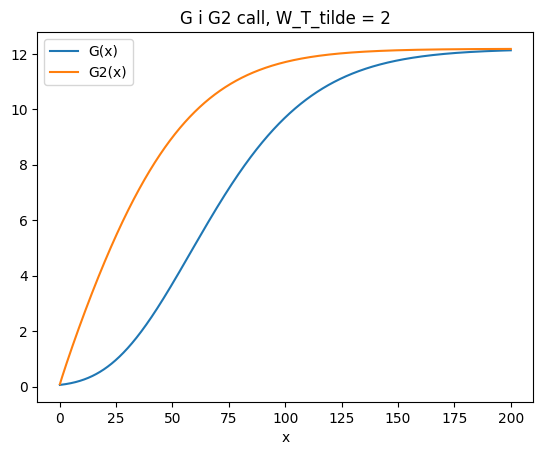

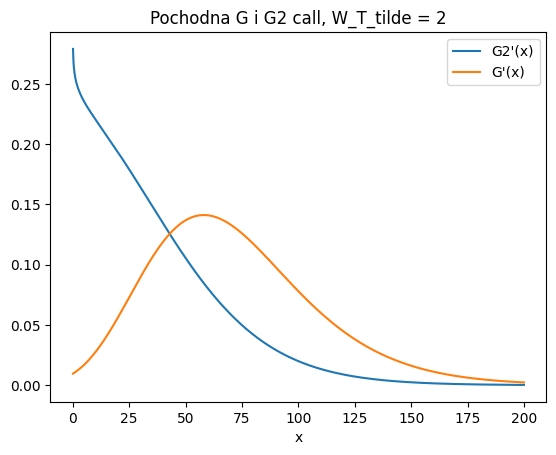

In [13]:
df_call.plot(x = 'x', y = [1,2], title = f"G i G2 call, W_T_tilde = {W_T_tilde}")
df_call.plot(x = 'x', y = [3,4], title = f"Pochodna G i G2 call, W_T_tilde = {W_T_tilde}")

In [27]:
W_T_tilde = -5
rho = 0.5
delta = 0.1
x_put = np.arange(delta, K, delta)
df_put = pd.DataFrame({ "x" : x_call, "G(x)" : None, "G2(x)" : None, "G'(x)" : None,"G2'(x)" : None})
for i in range(len(x_put)):
    df_put.at[i, "G(x)"] = G_func(df_put.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = "put", target_function = 1, derivative = False)
    df_put.at[i, "G2(x)"] = G_func(df_put.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = "put", target_function = 2, derivative = False)
    df_put.at[i, "G'(x)"] = G_func(df_put.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = "put", target_function = 1, derivative = True)
    df_put.at[i, "G2'(x)"] = G_func(df_put.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = "put", target_function = 2, derivative = True)

<Axes: title={'center': 'Pochodna  G i G2 put, W_T_tilde = -5'}, xlabel='x'>

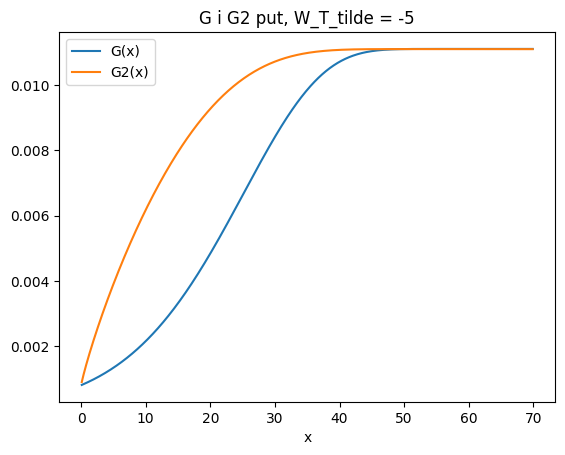

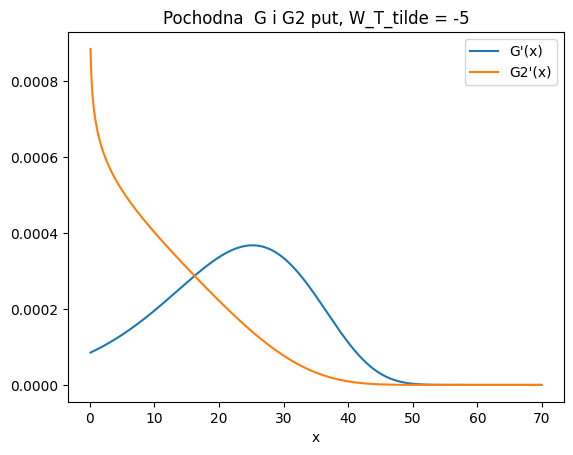

In [28]:
df_put.plot(x = 'x', y = [1,2], title = f"G i G2 put, W_T_tilde = {W_T_tilde}")
df_put.plot(x = 'x', y = [3,4], title = f"Pochodna  G i G2 put, W_T_tilde = {W_T_tilde}")

Znajdowanie $x$ takiego, że $G'(x)=m$

In [32]:
def get_coefficients(m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho):
    m_tilde = m / dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)
    a = 1
    b = 2 * sigma ** 2 * T * (1 - rho ** 2 ) - 2 * np.log(S0) - 2 * mu * T + sigma ** 2 * T - 2 * rho * sigma * W_T_tilde
    c = np.log(m_tilde * sigma * np.sqrt(2 * np.pi * T * (1 - rho ** 2))) * (2 * sigma ** 2 * T * (1 - rho ** 2 )) + (-np.log(S0) - mu * T + sigma ** 2 * T * 0.5 - rho * sigma * W_T_tilde) ** 2 
    return a, b, c

def get_delta(a, b, c):
    return b ** 2 - 4 * a * c

def wrapping_function(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type, arg_inf, m):
    return G_func(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type, 2, True, arg_inf) - m

def find_x(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0,  rho, type = 'call', target_function = 1,  left_bound = 0.01,eps = 0.1 ** 10, right_bound = 100, arg_inf = 120):
    if target_function == 1:
        coef = get_coefficients(m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
        delta = get_delta(*coef)
        if delta < 0:
            return 0
        elif delta == 0:
            if type == 'call':
                x = (np.exp( -1 * coef[1] / (2 * coef[0])) - K)
            elif type == 'put':
                x = -(np.exp( -1 * coef[1] / (2 * coef[0])) - K)
            else:
                raise Exception("Wrong type")
        else:
            if type == 'call':
                x = np.exp(( -1 * coef[1] + np.sqrt(delta)) / (2 * coef[0] )) - K
            elif type == 'put':
                x = -np.exp(( -1 * coef[1] - np.sqrt(delta)) / (2 * coef[0] )) + K
            else:
                raise Exception("Wrong type")
        if x < 0:
            return 0
        b = G_func(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type) - m * x
        if G_func(left_bound, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type) -m * left_bound - b > 0:
            return 0
        return x
    elif target_function == 2:
        x0 = G_func(left_bound, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type, target_function = 2, derivative = True)
        if m > x0:
            return 0
        if type == "call":
            while True:
                if(G_func(right_bound, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type, target_function, derivative = True) < m):
                    break
                else:
                    right_bound = 2 * right_bound
                if(right_bound > 10 ** 6):
                    raise Exception("m too small")  
        elif type == "put":
            right_bound = K - 0.001
        return (root_scalar(wrapping_function, args = (mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type, arg_inf, m), bracket= (left_bound, right_bound), method = "bisect", rtol= eps).root)


In [60]:
def plot_line_G(x, m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = 'call', grid_step = 0.1, x_range = 50, target_function = 1, kind_of_plot = 'diff'):
    if type == 'put' and  x_range > K:
        x_range = K
    x_grid = np.arange(grid_step, x_range, grid_step)
    df = pd.DataFrame({ "x" : x_grid, "G(x)" : None, "Line" : None, "Diff" : None})
    if target_function == 1:
        string = "G(x)"
    else:
        string = "G2(x)"
        
    for i in range(len(x_grid)):
        if type == 'call':
            b = G_func(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type, target_function) - m * x
            df.at[i, string] = G_func(df.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type, target_function)
            df.at[i, "Line"] = m * df.at[i, 'x'] + b
            df.at[i, "Diff"] = df.at[i, "Line"] - df.at[i, string] 
        else:
            b = G_func(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type, target_function) - m * x
            df.at[i, string] = G_func(df.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type, target_function)
            df.at[i, "Line"] = m * df.at[i, 'x'] + b
            df.at[i, "Diff"] = df.at[i, "Line"] - df.at[i, string]

    #df.plot(x = 'x', y = [1,2])
    if kind_of_plot == 'diff':
        df.plot(x = 'x', y = [3], title = f"Target function = {target_function}, W_tilde = {W_T_tilde}, type = {type}")
    else:
        df.plot(x = 'x', y = [string,"Line"], title = f"Target function = {target_function}, W_tilde = {W_T_tilde}, type = {type}")
    return 0
    
       


116.24134627866997

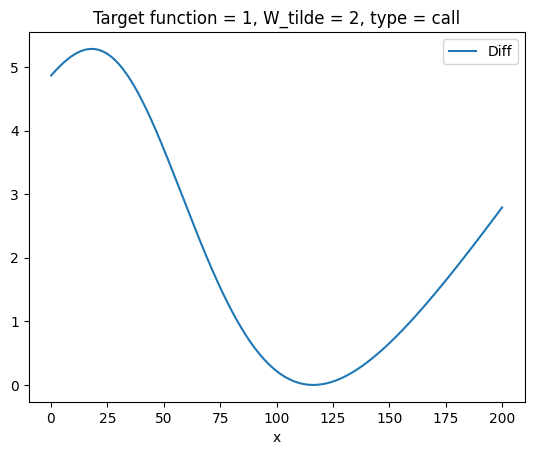

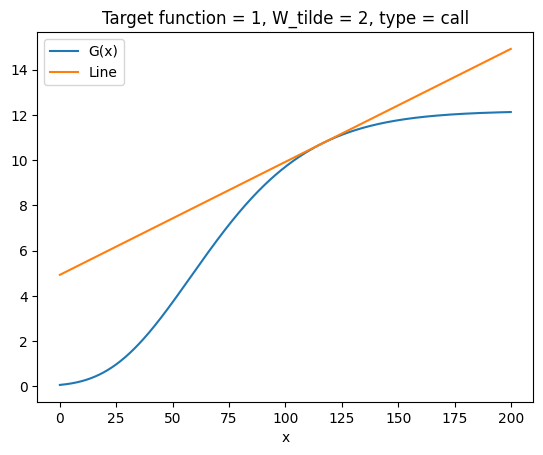

In [61]:
W_T_tilde = 2
m = 0.05
plot_line_G(find_x(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'call'), m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = 'call', grid_step = 0.1, x_range = 200, kind_of_plot = 'diff')
plot_line_G(find_x(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'call'), m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = 'call', grid_step = 0.1, x_range = 200, kind_of_plot = "G(x) and line")
find_x(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'call')

116.24134627866997

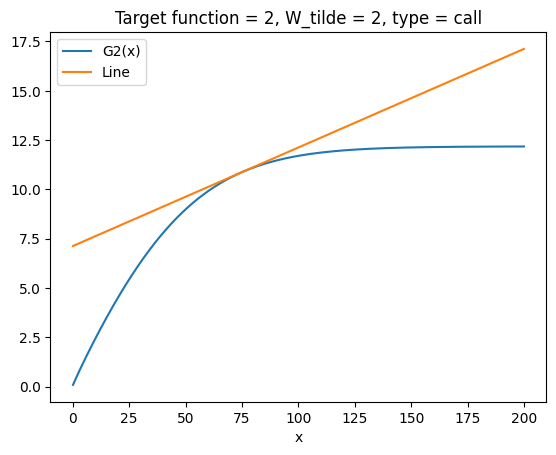

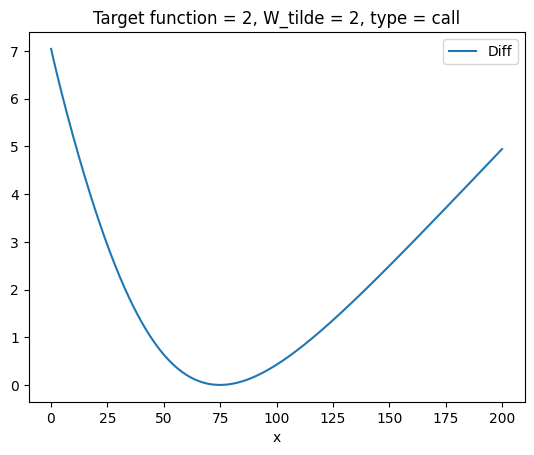

In [62]:
m= 0.05
W_T_tilde = 2

plot_line_G(find_x(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'call', target_function = 2), m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = 'call', target_function = 2, grid_step = 0.1, x_range = 200, kind_of_plot = "G(x) and line")
plot_line_G(find_x(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'call', target_function = 2), m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = 'call', target_function = 2, grid_step = 0.1, x_range = 200, kind_of_plot = "diff")
find_x(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'call')

16.213918350930577

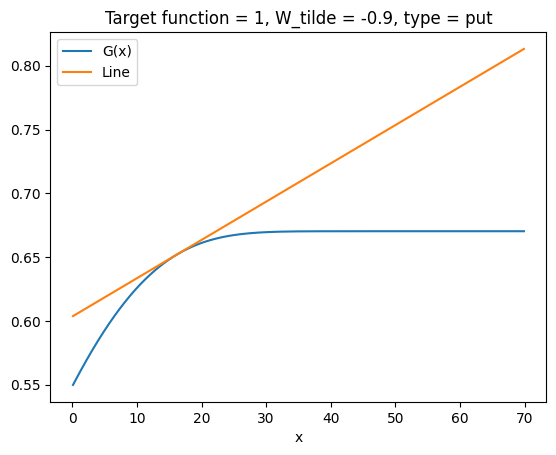

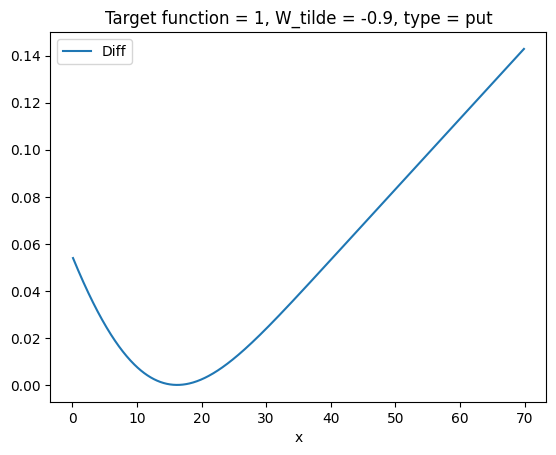

In [63]:
m= 0.003
W_T_tilde = -0.9

plot_line_G(find_x(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'put'), m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = 'put', grid_step = 0.1, x_range = 200, kind_of_plot = "G(x) and line")
plot_line_G(find_x(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'put'), m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = 'put', grid_step = 0.1, x_range = 200, kind_of_plot = "diff")
find_x(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'put')

16.213918350930577

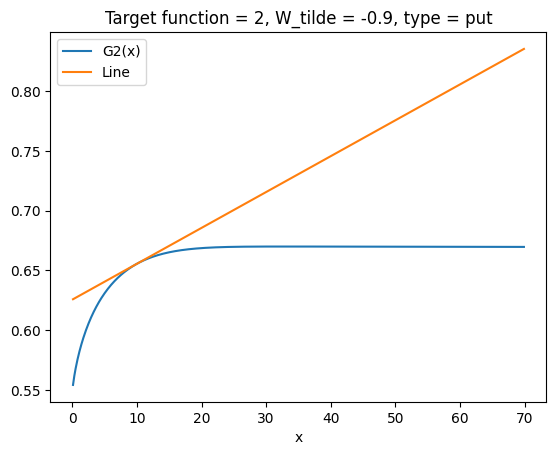

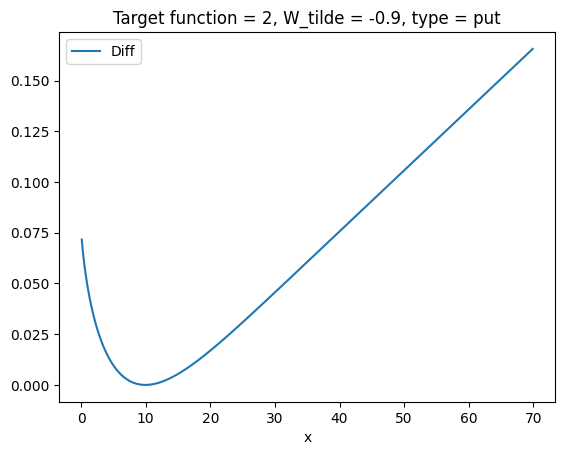

In [64]:
m= 0.003
W_T_tilde = -0.9

plot_line_G(find_x(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'put', target_function = 2), m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = 'put', grid_step = 0.1, x_range = 200, kind_of_plot = "G(x) and line", target_function = 2)
plot_line_G(find_x(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'put', target_function = 2), m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = 'put', grid_step = 0.1, x_range = 200, kind_of_plot = "diff", target_function = 2)
find_x(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'put')